In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 14 12:53:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 


In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 446 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random import sample
from collections import OrderedDict



#Sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

#matplot
import matplotlib.pyplot as plt



#embedding
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.callbacks import PerplexityMetric
# tqdm
from tqdm.notebook import tqdm

#tensorflow
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Flatten,Dense
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K

#os
import os





# Load Data And EDA

In [ ]:
train_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/train.json"
test_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/test.json"

with open(train_file_path, 'r') as f:
    data = json.load(f)
df_train = pd.DataFrame(data)

with open(test_file_path, 'r') as f:
    data = json.load(f)
df_test = pd.DataFrame(data)

#Concate title and abstract
df_train['title_abstract'] = df_train['title'] + df_train['abstract']
df_test['title_abstract'] = df_test['title'] + df_test['abstract']

In [ ]:
df_train

,authors,year,abstract,venue,title,title_abstract
0,"[42, 13720, 36]",9,"[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",20,"[41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...","[41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1..."
1,"[1359, 15881, 45]",15,"[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",2,"[1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...","[1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3..."
2,"[19166, 17763]",17,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...",,"[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...","[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159..."
3,[97],10,"[46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...",4,"[40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...","[40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5..."
4,"[19617, 2]",10,"[37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...",9,"[38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...","[38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,..."
...,...,...,...,...,...,...
25788,"[1797, 78]",14,"[46, 1605, 1681, 10, 1557, 4741, 1535, 2021, 1...",1,"[46, 1910, 36, 2107, 1547, 1553, 1716, 1528, 5...","[46, 1910, 36, 2107, 1547, 1553, 1716, 1528, 5..."
25789,"[18357, 11563, 7905]",11,"[46, 1605, 1691, 10, 2551, 4168, 2030, 3134, 1...",278,"[47, 1574, 1541, 1549, 47, 1966, 2114, 112, 12...","[47, 1574, 1541, 1549, 47, 1966, 2114, 112, 12..."
25790,"[2236, 20436, 10501]",7,"[1611, 1543, 1535, 2817, 2073, 1647, 11, 2933,...",17,"[56, 1718, 3012, 56, 1902, 2160, 1546, 1623, 1...","[56, 1718, 3012, 56, 1902, 2160, 1546, 1623, 1..."
25791,"[3921, 8760]",16,"[37, 1662, 33, 2007, 1669, 4981, 1650, 1527, 1...",0,"[3066, 1728, 11, 1546, 11, 3066, 1728, 1531, 1...","[3066, 1728, 11, 1546, 11, 3066, 1728, 1531, 1..."


## Select the proper data

In [ ]:
# author feature is used to retreive the corresponding labels and the coauthor feature is used for further training

# Retrieve the non-prolific author and prolific author index
non_prolific_author_index = []
prolific_author_index = []
for i,j in enumerate(df_train['authors']):
  contain_pauthor = False
  for k in j:
    if k < 100 and k >= 0:
      contain_pauthor = True
  if contain_pauthor == False:
    non_prolific_author_index.append(i)
  else:
    prolific_author_index.append(i)

df_non_prolifc_authors = df_train.drop(prolific_author_index)
df_prolific_authors = df_train.drop(non_prolific_author_index)
df_prolific_authors = pd.DataFrame(np.repeat(df_prolific_authors.values, 1, axis=0),columns=df_prolific_authors.columns)


# create a new column for coauthor of prolific author dataframe
prolific_author_label = []
non_prolific_author_label = []
for i in df_prolific_authors['authors']:
  prolific_author_label_each_instance = []
  non_prolific_author_label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      prolific_author_label_each_instance.append(j)
    else:
      non_prolific_author_label_each_instance.append(j)
  prolific_author_label.append(prolific_author_label_each_instance)
  non_prolific_author_label.append(non_prolific_author_label_each_instance)

#Creat a new column for futher training features

df_prolific_authors['coauthors'] = non_prolific_author_label

# get the corresponding percentage of non prolific author

selected_col_nums = 2500
non_prolific_author_rows = sample(range(18333),selected_col_nums)
df_selected_non_prolific_authors = df_non_prolifc_authors.iloc[non_prolific_author_rows]
df_selected_non_prolific_authors['coauthors'] = df_selected_non_prolific_authors.loc[:,'authors']


df_selected_data = pd.concat([df_selected_non_prolific_authors, df_prolific_authors], axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## ohe for venue and coauthor

In [ ]:
# fill the empty string value of the title with 466
def venue_preprocessing(df):
  venue_list = []
  for i in df['venue']:
    if i == '':
      venue_list.append(465)
    else:
      venue_list.append(i)
  # df = df.drop(['venue'],axis = 1)
  # df['venue'] =venue_list
  return venue_list

def make_venue_ohe(venue_list):
  total_array = np.zeros((len(venue_list),max(venue_list) + 1))
  for n,i in enumerate(venue_list):
    total_array[n,i] = 1
  return total_array


# Handle the situation where the coauthor does not contain value
def coauthor_preprocessing(df):
  total_list = []
  for i in df['coauthors']:
    coauthor_instance = []
    for j in i:
      coauthor_instance.append(j)
    if len(coauthor_instance) == 0:
      coauthor_instance.append(21246)
    total_list.append(coauthor_instance)
  return total_list

def make_coauthor_ohe(coauthor_list):
  total_array = np.zeros((len(coauthor_list),21247))
  for n,i in enumerate(coauthor_list):
    for j in i:
      total_array[n,j] = 1
  return total_array




In [ ]:
venue_array = make_venue_ohe(venue_preprocessing(df_selected_data))
coauthor_array = make_coauthor_ohe(coauthor_preprocessing(df_selected_data))

In [ ]:
df_selected_data

,authors,year,abstract,venue,title,title_abstract,coauthors
9955,"[7862, 1090]",16,"[46, 1605, 1691, 10, 1557, 1662, 1529, 1701, 1...",32,"[2085, 1719, 1846, 1529, 1589, 1629, 47, 1603,...","[2085, 1719, 1846, 1529, 1589, 1629, 47, 1603,...","[7862, 1090]"
25202,"[974, 16424]",15,"[1731, 1691, 2449, 33, 1910, 1701, 1553, 1535,...",,"[37, 2321, 1746, 1535, 2079, 4699, 3113, 1704,...","[37, 2321, 1746, 1535, 2079, 4699, 3113, 1704,...","[974, 16424]"
15433,"[19199, 3787, 14762]",8,"[40, 1542, 1691, 2380, 33, 1910, 1692, 1553, 1...",11,"[33, 1585, 1534, 37, 1632, 56, 1687, 1644]","[33, 1585, 1534, 37, 1632, 56, 1687, 1644, 40,...","[19199, 3787, 14762]"
17954,"[5319, 9442, 18459, 10156]",18,"[46, 2502, 1542, 1593, 1622, 2240, 1947, 1810,...",31,"[11, 1539, 1615, 1966, 11, 3521, 1653, 3318, 2...","[11, 1539, 1615, 1966, 11, 3521, 1653, 3318, 2...","[5319, 9442, 18459, 10156]"
9877,"[10996, 8625, 9840]",15,"[40, 1542, 1691, 2449, 1635, 1706, 1556, 2615,...",70,"[1635, 24, 53, 1546, 1752, 1566, 11, 2209, 53,...","[1635, 24, 53, 1546, 1752, 1566, 11, 2209, 53,...","[10996, 8625, 9840]"
...,...,...,...,...,...,...,...
7455,"[19974, 68, 8903]",1,"[40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...",23,"[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...","[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...","[19974, 8903]"
7456,"[6353, 67, 3037, 15856, 13521]",10,"[40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...",10,"[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...","[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...","[6353, 3037, 15856, 13521]"
7457,"[7686, 3810, 87, 7451]",16,"[2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...",31,"[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...","[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...","[7686, 3810, 7451]"
7458,"[14864, 92]",16,"[37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...",0,"[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...","[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...",[14864]


## abstract and title concate doc2vec

In [ ]:
# #abstract and title doc to vec
# def convert_to_string(df):
#   total_list = []
#   for i in df:
#     per_instance = []
#     for j in i:
#       per_instance.append(str(j))
#     total_list.append(per_instance)
#   return total_list
# #Use all the provided data to train
# text_title_abs = convert_to_string(df_train['title_abstract'])


class EpochLogger(CallbackAny2Vec):
  def __init__(self):
      self.epoch = 0
  def on_epoch_begin(self, model):
      print("Epoch #{} start".format(self.epoch))
  def on_epoch_end(self, model):
         print("Epoch #{} end".format(self.epoch))
         self.epoch += 1

     

epoch_logger = EpochLogger()      

     

    


title_abstract = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_train['title_abstract'])]
title_abstract_model = Doc2Vec(title_abstract, vector_size=256, window= 4, min_count=1, workers=4,callbacks=[epoch_logger],epochs = 10)


Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


In [ ]:
def get_vector_rep(df,model,vec_len):
  total_vec = np.zeros((len(df),vec_len))
  for n,i in tqdm(enumerate(df)):
    vector = model.infer_vector(i)
    total_vec[n] = vector
  return total_vec
# text_title_abs = convert_to_string(df_selected_data['title_abstract'])
title_abs_rep = get_vector_rep(df_selected_data['title_abstract'],title_abstract_model,256)

0it [00:00, ?it/s]

TypeError: ignored

## One-Hot-label

In [ ]:
#One-hot encoding the labels

total_label = []
for i in df_selected_data['authors']:
  label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      label_each_instance.append(j)
  if len(label_each_instance) == 0:
    label_each_instance.append(100)
  total_label.append(label_each_instance)


multilable_binarizer = MultiLabelBinarizer()
ohe_prolific_labels = multilable_binarizer.fit_transform(total_label).astype('float')
ohe_prolific_labels.shape

(9960, 100)

#Tensorflow


In [ ]:
total_features = np.concatenate((coauthor_array,venue_array,title_abs_rep),axis = 1)
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(title_abs_rep)
# df = pd.DataFrame(scaled_features)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(coauthor_array,ohe_prolific_labels,test_size=0.1,random_state=90051)

In [ ]:
checkpoint_path = 'model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                              save_best_only=True,
                                              monitor = 'val_loss',
                                              mode='min')


inputs = keras.Input(shape=(X_train.shape[1],))
# dense3 = layers.Dense(1024, activation="relu")(inputs)
# dp3 = layers.Dropout(0.3)(dense3)
# dense4 = layers.Dense(512, activation="relu")(inputs)
# dp4 = layers.Dropout(0.3)(dense4)
dense5 = layers.Dense(256, activation="relu")(inputs)
dp5 = layers.Dropout(0.3)(dense5)
dense6 = layers.Dense(100, activation="sigmoid")(dp5)

model = keras.Model(inputs, dense6)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 21247)]           0         
                                                                 
 dense_21 (Dense)            (None, 256)               5439488   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 100)               25700     
                                                                 
Total params: 5,465,188
Trainable params: 5,465,188
Non-trainable params: 0
_________________________________________________________________


In [ ]:
metrics = tf.keras.metrics.CategoricalAccuracy()
METRICS = [
      # keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      tfa.metrics.F1Score(num_classes=100,threshold = 0.3, average='macro')
]


# loss = tfa.metrics.HammingLoss(mode='multilabel', threshold=0.5)

# loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2,from_logits=False)
# loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.BinaryCrossentropy()



optimizer = optimizers.Adam(learning_rate =0.001)
model.compile(loss= loss, optimizer= optimizer, metrics = METRICS)

history = model.fit(X_train,y_train, epochs = 80, batch_size= 128,callbacks = [callback], validation_data =(X_test,y_test),shuffle = True)
# history = model.fit(X_train,y_train, epochs = 50, batch_size= 64, validation_data =(X_test,y_test),shuffle = True)

Epoch 1/80
70/71 [============================>.] - ETA: 0s - loss: 0.0045 - recall: 0.8921 - f1_score: 0.9178

KeyboardInterrupt: ignored

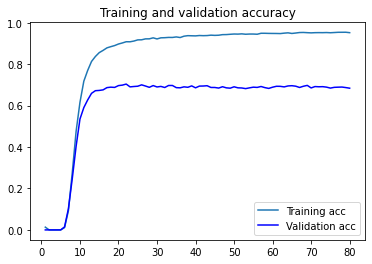

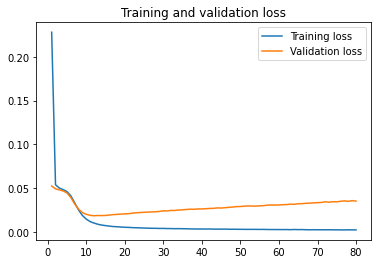

In [ ]:
model.load_weights(checkpoint_path)
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred_train = model.predict(X_train)
predicted_train = np.where(y_pred_train < 0.5,0,1)
a = f1_score(y_train, predicted_train, average='samples')
a

281/281 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.0

In [ ]:
y_pred = model.predict(X_test)
score_list = []
for i,j in enumerate(np.linspace(0, 1, 21)):
  predicted_val = np.where(y_pred < j, 0, 1)
  a = f1_score(y_test, predicted_val, average='samples')
  score_list.append((round(i*0.05,3),a))
score_list

32/32 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-pack

[(0.0, 0.01696143368775623),
 (0.05, 0.0),
 (0.1, 0.0),
 (0.15, 0.0),
 (0.2, 0.0),
 (0.25, 0.0),
 (0.3, 0.0),
 (0.35, 0.0),
 (0.4, 0.0),
 (0.45, 0.0),
 (0.5, 0.0),
 (0.55, 0.0),
 (0.6, 0.0),
 (0.65, 0.0),
 (0.7, 0.0),
 (0.75, 0.0),
 (0.8, 0.0),
 (0.85, 0.0),
 (0.9, 0.0),
 (0.95, 0.0),
 (1.0, 0.0)]

## Test set

In [ ]:


test_venue_array = make_venue_ohe(venue_preprocessing(df_test))
test_coauthor_array = make_coauthor_ohe(coauthor_preprocessing(df_test))
test_title_abs_rep = get_vector_rep(df_test['title_abstract'],title_abstract_model,256)

test_total_features = np.concatenate((test_coauthor_array,test_venue_array,test_title_abs_rep),axis = 1)
# test_scaler = StandardScaler()
# test_scaled_features = test_scaler.fit_transform(test_total_features)
# df_test_concated_scaled = pd.DataFrame(test_scaled_features)

0it [00:00, ?it/s]

In [ ]:

test_prediction = model.predict(test_total_features)

prediction = np.where(test_prediction < 0.03, 0, 1)

25/25 [==============================] - 0s 3ms/step


In [ ]:
test_prediction[2]

array([6.89656281e-06, 6.77890639e-05, 4.67698323e-04, 9.09709634e-05,
       9.31544037e-06, 1.31197070e-04, 2.84133805e-03, 3.98193479e-05,
       1.30315078e-04, 5.93712139e-05, 3.24675348e-04, 2.35659216e-04,
       8.70880962e-04, 2.43855547e-03, 2.04303124e-05, 7.57240150e-06,
       2.04144933e-04, 1.25830527e-04, 8.33376427e-04, 3.81210266e-05,
       1.13408196e-05, 1.02314098e-05, 2.26880547e-06, 2.67418800e-04,
       1.97313289e-04, 4.97455985e-05, 9.54204666e-07, 6.16795878e-05,
       5.24191591e-06, 1.68260540e-05, 1.68912975e-05, 9.84360754e-01,
       2.68439850e-04, 1.77355723e-05, 4.36918526e-05, 1.13548986e-05,
       5.27448938e-05, 9.08100687e-04, 7.38186529e-04, 1.46090333e-05,
       2.81263124e-06, 1.39664207e-05, 5.49196338e-05, 2.64581249e-05,
       2.78701482e-05, 3.82565893e-04, 1.43114186e-04, 7.50868094e-06,
       9.10049785e-05, 1.58255643e-04, 5.29465615e-04, 8.19471257e-04,
       4.81872075e-06, 4.50258740e-05, 1.63374949e-04, 1.43543994e-05,
      

In [ ]:
prediction

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
predicted_list = [i.tolist() for i in prediction]
total_index_list = []
for i in predicted_list:
  index_list = []
  for j,k in enumerate(i):
    if k == 1: 
        index_list.append(str(j))
  if len(index_list) != 0:
    total_index_list.append(index_list)
  else:
    total_index_list.append([str(-1)])

predicted_str = []
for i in total_index_list:
  a = ','.join(i)
  predicted_str.append(a)

In [ ]:
# predicted_list = [i.tolist() for i in prediction]
# total_index_list = []
# for i in predicted_list:
#   index_list = []
#   for j,k in enumerate(i):
#     if k == 1: 
#       if j == 100:
#         index_list.append(str(-1))
#       else:
#         index_list.append(str(j))
#   if len(index_list) != 0:
#     total_index_list.append(index_list)
#   else:
#     total_index_list.append([str(-1)])

# predicted_str = []
# for i in total_index_list:
#   a = ','.join(i)
#   predicted_str.append(a)

In [ ]:
df_output = pd.DataFrame({'ID': list(range(800)),'Predict':predicted_str})
df_output.to_csv('predicted_result.csv',index = False)

In [ ]:
df_output['Predict'].values.tolist().count('-1') / 800

0.3475

In [ ]:
df_output

,ID,Predict
0,0,92
1,1,-1
2,2,31
3,3,"23,42"
4,4,32
...,...,...
795,795,54
796,796,97
797,797,"13,71"
798,798,"21,71"
